## Main code

In [1]:
import scipy
import scipy.linalg as linalg
import numpy as np
#!pip install igraph
import igraph as ig
import random
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
class NOTEARS:
  def __init__(self, weight_threshold, max_rho, max_iter, h_tol, lambda1, originalMethod = False):
    self.X = None
    self.weight_threshold = weight_threshold
    self.max_rho = max_rho
    self.max_iter = max_iter
    self.h_tol = h_tol
    self.lambda1 = lambda1
    self.rho = 1.0
    self.alpha = 1.0
    self.h = np.inf
    self.originalMethod = originalMethod
    self.b = 1.5

  def calc_h(self, W_flattened):
    d = self.X.shape[1]
    #W = W_flattened.reshape([d, d])
    W = self._adj(W_flattened)
    M = linalg.expm(W*W)
    h = np.trace(M) - d
    h_grad = 2* M.T * W
    return h, h_grad


  # Doesn't include regularization term
  def objective_and_gradient(self, W_flattened):
      d = self.X.shape[1]
      n = self.X.shape[0]

      #W = W_flattened.reshape([d, d])
      W = self._adj(W_flattened)

      # Just lasso regression loss
      R = self.X - self.X @ W
      loss = 1/(2*n) * (R**2).sum()
      grad_loss = -1.0/n * self.X.T @ R
      h, h_grad = self.calc_h(W_flattened)

      #objective_value = loss + self.rho/2 * h**2 + self.alpha*h
      #objective_gradient = grad_loss + (self.rho * h + self.alpha) * h_grad
      #objective_gradient = np.concatenate((objective_gradient + self.lambda1, []), axis=None)

      objective_value = loss + self.rho/2 * h**2 + self.alpha*h + self.lambda1*np.abs(W).sum()
      objective_gradient = grad_loss + (self.rho * h + self.alpha) * h_grad
      objective_gradient = np.concatenate((objective_gradient + self.lambda1, - objective_gradient + self.lambda1), axis=None)
      return objective_value, objective_gradient

  def _adj(self, w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        # Note doubled variables are for handling non-smooth regularization term
        return (w[:d * d] - w[d * d:]).reshape([d, d])


  def solve(self):
      d = self.X.shape[1]
      n = self.X.shape[0]
      # Starting guess for W; initialize rho, alpha
      W_est_flattened, self.rho, self.alpha = np.zeros(2*d*d), 1.0, 0.0
      rho_s = []
      alphas = []
      h_vals = []
      function_evals = 0

      # Set bounds for W_est matrix (basically diagonal elements must be zero.)
      #bnds = [(0, 0) if i == j else (0, None) for i in range(d) for j in range(d)]
      bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]

      # Perform Dual Gradient ascent to solve eq. (12) in paper
      if self.originalMethod:
              # Perform Dual Gradient ascent to solve eq. (12) in paper
          # Perform Dual Gradient ascent to solve eq. (12) in paper
          for i in range(1, self.max_iter, 1):
              rho_s.append(self.rho)
              alphas.append(self.alpha)
              print("Iteration " + str(i))

              while self.rho < self.max_rho:
                  subresult = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds)
                  W_next_flattened = subresult.x
                  function_evals += subresult.nfev
                  h_next, _ = self.calc_h(W_next_flattened)
                  #print(h_next)
                  if h_next > 0.25*self.h: self.rho*= 10
                  else: break

              W_est_flattened = W_next_flattened
              self.h = h_next
              self.alpha = self.alpha + self.rho*self.h
              print(self.h)
              h_vals.append(h_next)

              if self.h <= self.h_tol or self.rho >= self.max_rho: break
          # Threshold values lower than weight_threshold (omega)
          #W_est = W_est_flattened.reshape([d, d])
          W_est = self._adj(W_est_flattened)
          W_est[np.abs(W_est)< self.weight_threshold] = 0
          assert self.is_dag(W_est)
          np.savetxt('W_est.csv', W_est, delimiter=',')


          accuracy = self.count_accuracy(B_true, W_est != 0)
          print(accuracy)

      else:
        h_init, _ = self.calc_h(W_est_flattened)
        factor = 1
        alpha_init = self.alpha
        i = 1
        for iter in range(1, self.max_iter, 1):
            # Update rho
            self.rho = factor * self.b**i
            # Update tolerance
            epsilon_i = (1/self.rho)**0.25#**0.025
            rho_s.append(self.rho)
            alphas.append(self.alpha)
            print("Iteration " + str(iter))

            while self.rho < self.max_rho:
                  i+=1
                  subresult = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds, options = {'gtol' : epsilon_i })
                  W_next_flattened = subresult.x
                  function_evals += subresult.nfev
                  #print(W_next_flattened)
                  h_next, _ = self.calc_h(W_next_flattened)
                  if h_next > 0.25*self.h:
                    factor*= 10
                    # Update rho
                    self.rho = factor * self.b**i
                    # Update tolerance
                    epsilon_i = (1/self.rho)**0.25
                  else: break

            #W_next_flattened = scipy.optimize.minimize(self.objective_and_gradient,
            #                                           W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds, options = {'gtol' : epsilon_i }).x
            #h_next, _ = self.calc_h(W_next_flattened)
            print(h_next)
            h_vals.append(h_next)
            W_est_flattened = W_next_flattened
            self.h = h_next


            #Update alpha
            dual_step_size = self.rho*np.minimum(1, 1*np.log(2)**2/(self.h*(i+1)*np.log(i+2)**2))
            #self.alpha = self.alpha + self.rho*self.h
            self.alpha = self.alpha + dual_step_size*self.h
            i+=1


            if self.h <= self.h_tol or self.rho >= self.max_rho:
              self.rho = self.max_rho
              W_est_flattened = scipy.optimize.minimize(self.objective_and_gradient, W_est_flattened, method='L-BFGS-B', jac=True, bounds = bnds).x
              self.h, _ = self.calc_h(W_next_flattened)
              break

        # Threshold values lower than weight_threshold (omega)
        W_est = self._adj(W_est_flattened)
        W_est[np.abs(W_est)< self.weight_threshold] = 0
        assert self.is_dag(W_est)
        np.savetxt('W_est.csv', W_est, delimiter=',')


        accuracy = self.count_accuracy(B_true, W_est != 0)
        print(accuracy)

      print(self.objective_and_gradient)
      return W_est, rho_s, alphas, accuracy, function_evals, h_vals


  ### Helper functions to generate/simulate DAG (i.e. our synthetic data) (copied from NOTEARS code)
  def is_dag(self, W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

  def simulate_parameter(self, B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


  def simulate_dag(self, d, s0, graph_type):
      """Simulate random DAG with some expected number of edges.

      Args:
          d (int): num of nodes
          s0 (int): expected num of edges
          graph_type (str): ER, SF, BP

      Returns:
          B (np.ndarray): [d, d] binary adj matrix of DAG
      """
      def _random_permutation(M):
          # np.random.permutation permutes first axis only
          P = np.random.permutation(np.eye(M.shape[0]))
          return P.T @ M @ P

      def _random_acyclic_orientation(B_und):
          return np.tril(_random_permutation(B_und), k=-1)

      def _graph_to_adjmat(G):
          return np.array(G.get_adjacency().data)

      if graph_type == 'ER':
          # Erdos-Renyi
          G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
          B_und = _graph_to_adjmat(G_und)
          B = _random_acyclic_orientation(B_und)
      elif graph_type == 'SF':
          # Scale-free, Barabasi-Albert
          G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
          B = _graph_to_adjmat(G)
      elif graph_type == 'BP':
          # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
          top = int(0.2 * d)
          G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
          B = _graph_to_adjmat(G)
      else:
          raise ValueError('unknown graph type')
      B_perm = _random_permutation(B)
      assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
      return B_perm

  def simulate_linear_sem(self, W, n, sem_type, noise_scale=None):
      """Simulate samples from linear SEM with specified type of noise.

      For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

      Args:
          W (np.ndarray): [d, d] weighted adj matrix of DAG
          n (int): num of samples, n=inf mimics population risk
          sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
          noise_scale (np.ndarray): scale parameter of additive noise, default all ones

      Returns:
          X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
      """
      def _simulate_single_equation(X, w, scale):
          """X: [n, num of parents], w: [num of parents], x: [n]"""
          if sem_type == 'gauss':
              z = np.random.normal(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'exp':
              z = np.random.exponential(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'gumbel':
              z = np.random.gumbel(scale=scale, size=n)
              x = X @ w + z
          elif sem_type == 'uniform':
              z = np.random.uniform(low=-scale, high=scale, size=n)
              x = X @ w + z
          elif sem_type == 'logistic':
              x = np.random.binomial(1, scipy.special.expit(X @ w)) * 1.0
          elif sem_type == 'poisson':
              x = np.random.poisson(np.exp(X @ w)) * 1.0
          else:
              raise ValueError('unknown sem type')
          return x

      d = W.shape[0]
      if noise_scale is None:
          scale_vec = np.ones(d)
      elif np.isscalar(noise_scale):
          scale_vec = noise_scale * np.ones(d)
      else:
          if len(noise_scale) != d:
              raise ValueError('noise scale must be a scalar or has length d')
          scale_vec = noise_scale
      if not self.is_dag(W):
          raise ValueError('W must be a DAG')
      if np.isinf(n):  # population risk for linear gauss SEM
          if sem_type == 'gauss':
              # make 1/d X'X = true cov
              X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
              return X
          else:
              raise ValueError('population risk not available')
      # empirical risk
      G = ig.Graph.Weighted_Adjacency(W.tolist())
      ordered_vertices = G.topological_sorting()
      assert len(ordered_vertices) == d
      X = np.zeros([n, d])
      for j in ordered_vertices:
          parents = G.neighbors(j, mode=ig.IN)
          X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
      return X

  def count_accuracy(self, B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not self.is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}

Sample test run

In [ ]:
solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
n, d, s0, graph_type, sem_type = 200, 20, 40, 'ER', 'gauss'
solver.d = d
B_true = solver.simulate_dag(d, s0, graph_type)
W_true = solver.simulate_parameter(B_true)
np.savetxt('W_true.csv', W_true, delimiter=',')

solver.X = solver.simulate_linear_sem(W_true, n, sem_type)
np.savetxt('X.csv', solver.X, delimiter=',')

In [ ]:
%%time
W_est, rhos, alphas, _, _, _ = solver.solve()

Iteration 1
0.8425996625018328
Iteration 2
0.08039877326525158
Iteration 3
0.018961237266193365
Iteration 4
0.0017385196808739067
Iteration 5
0.00041439927047193237
Iteration 6
8.697190208550865e-05
Iteration 7
7.84833375533367e-06
Iteration 8
8.972341056789901e-07
Iteration 9
1.0938883931999044e-07
Iteration 10
1.3375149876537762e-08
Iteration 11
3.47375461728916e-09
{'fdr': 0.15555555555555556, 'tpr': 0.95, 'fpr': 0.04666666666666667, 'shd': 7, 'nnz': 45}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fb0e1c3e050>>
CPU times: user 13.2 s, sys: 12.8 s, total: 26 s
Wall time: 25.5 s


In [ ]:
solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = False)
solver2.d = d
solver2.X = solver.X

In [ ]:
%%time
W_est_new_ours, rhos_ours, alphas_ours, _ , _, _= solver2.solve()

Iteration 1
0.7731522369914572
Iteration 2
0.12837845723324648
Iteration 3
0.019803282054525084
Iteration 4
0.0025534799647672912
Iteration 5
0.0003672507581171658
Iteration 6
6.002725313081214e-05
Iteration 7
1.0623732546122255e-05
Iteration 8
2.2344866330570312e-06
Iteration 9
1.8507097365727532e-07
Iteration 10
4.564904543258308e-08
Iteration 11
6.03360561513e-09
{'fdr': 0.3, 'tpr': 0.875, 'fpr': 0.1, 'shd': 19, 'nnz': 50}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7c2d3c69cf10>>
CPU times: user 10.6 s, sys: 8.73 s, total: 19.4 s
Wall time: 11.3 s


Text(0.5, 0, 'Iteration')

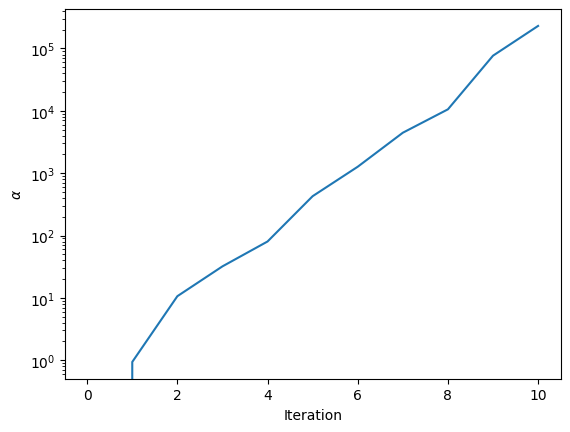

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(alphas)
plt.ylabel(r'$\alpha$')
plt.xlabel('Iteration')


Text(0.5, 0, 'Iteration')

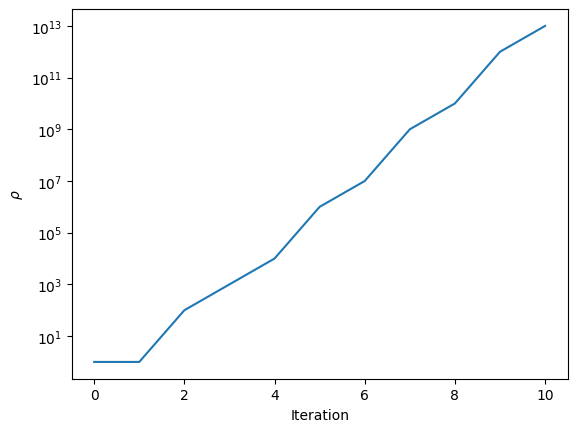

In [ ]:
plt.semilogy(rhos)
plt.ylabel(r'$\rho$')
plt.xlabel('Iteration')

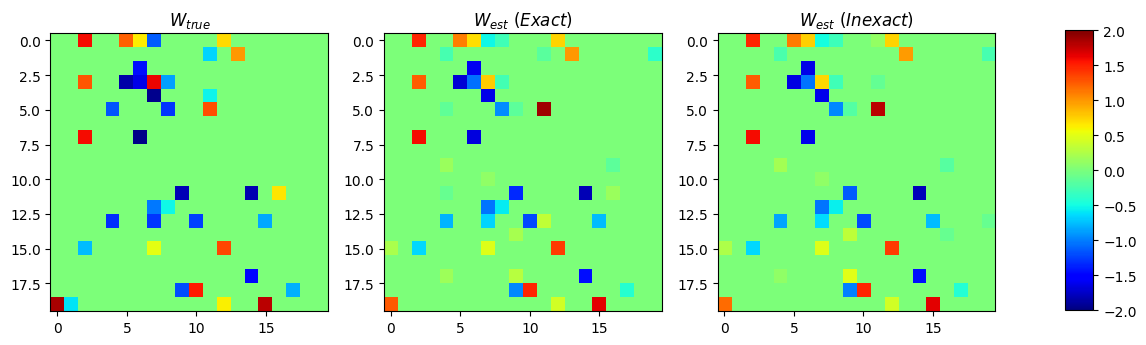

In [ ]:
import matplotlib.pyplot as plt
sns.reset_orig()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

#for ax in axes.flat:
im = ax1.imshow(W_true, vmin=-2, vmax=2, cmap='jet')
ax1.set_title(r'$W_{true}$')
im = ax2.imshow(W_est, vmin=-2, vmax=2, cmap='jet')
ax2.set_title(r'$W_{est}\  (Exact)$')
im = ax3.imshow(W_est_new_ours, vmin=-2, vmax=2, cmap='jet')
ax3.set_title(r'$W_{est}\  (Inexact)$')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Plots/Simulations with Synthetic Data

In [3]:
sns.set() # Setting seaborn as default style even if use only matplotlib
plt.show()
import time

d_vals = [10, 20, 40, 60]
num_of_simulations = 10
n = 1000

# Placeholders for metric results for all simulations

full_exp_shd_results_original = []
full_exp_fdr_results_original = []
full_exp_tpr_results_original = []
full_exp_fpr_results_original = []
full_exp_shd_results_ours = []
full_exp_fdr_results_ours = []
full_exp_tpr_results_ours = []
full_exp_fpr_results_ours = []


full_gauss_shd_results_original = []
full_gauss_fdr_results_original = []
full_gauss_tpr_results_original = []
full_gauss_fpr_results_original = []
full_gauss_shd_results_ours = []
full_gauss_fdr_results_ours = []
full_gauss_tpr_results_ours = []
full_gauss_fpr_results_ours = []


full_gumbel_shd_results_original = []
full_gumbel_fdr_results_original = []
full_gumbel_tpr_results_original = []
full_gumbel_fpr_results_original = []
full_gumbel_shd_results_ours = []
full_gumbel_fdr_results_ours = []
full_gumbel_tpr_results_ours = []
full_gumbel_fpr_results_ours = []

# Placeholders for timing results for all simulations
exp_original_times = []
gauss_original_times = []
gumbel_original_times = []

exp_our_times = []
gauss_our_times = []
gumbel_our_times = []

rhos_original = []
rhos_ours = []
hs_original = []
hs_ours = []

function_calls_original = []
function_calls_ours = []

for graph_type in ['SF']:
    for noise_type in ['exp', 'gauss', 'gumbel']:
        for d in d_vals:
            for i in np.arange(num_of_simulations + 1):

              print('Starting Simulation #' + str(i+1))
              param_tuple = (graph_type, noise_type, str(d))
              print(", ".join(param_tuple))

              solver = NOTEARS(weight_threshold= 0.2, max_rho= 1e16, max_iter= 100, h_tol= 1e-7, lambda1= 0.1, originalMethod = True)
              if graph_type == 'ER':
                n, d, s0, graph_type, sem_type = n, d, 2*d, graph_type, noise_type
              if graph_type == 'SF':
                n, d, s0, graph_type, sem_type = n, d, 2*d, graph_type, noise_type
              solver.d = d
              B_true = solver.simulate_dag(d, s0, graph_type)
              W_true = solver.simulate_parameter(B_true)
              np.savetxt('W_true.csv', W_true, delimiter=',')


              solver.X = solver.simulate_linear_sem(W_true, n, sem_type)
              np.savetxt('X.csv', solver.X, delimiter=',')

              print('Starting Exact Method')
              try:
                start = time.time()
                W_est_new, rhos, alphas, accuracy, func_calls, h_vals = solver.solve()
              except Exception: print('')
              stop = time.time()
              duration = stop-start

              rhos_original.append(rhos)
              hs_original.append(h_vals)
              function_calls_original.append(func_calls)

              if noise_type == 'exp':
                exp_original_times.append(duration)
              if noise_type == 'gauss':
                gauss_original_times.append(duration)
              if noise_type == 'gumbel':
                gumbel_original_times.append(duration)


              solver2 = NOTEARS(weight_threshold= 0.2, max_rho= 1e16, max_iter= 100, h_tol= 1e-7, lambda1= 0.1, originalMethod = False)
              solver2.d = d
              solver2.X = solver.X

              #%%time
              print('Starting Inexact Method')
              try:
                start = time.time()
                W_est_new_ours, rhos_ours, alphas_ours, accuracy_ours, func_calls_ours, h_vals_ours = solver2.solve()

              except Exception: print('')
              stop = time.time()
              duration = stop-start

              rhos_ours.append(rhos_ours)
              hs_ours.append(h_vals_ours)
              function_calls_ours.append(func_calls_ours)


              if noise_type == 'exp':
                exp_our_times.append(duration)
              if noise_type == 'gauss':
                gauss_our_times.append(duration)
              if noise_type == 'gumbel':
                gumbel_our_times.append(duration)


              if noise_type == 'exp' and graph_type == 'ER':

                full_exp_shd_results_original.append(accuracy["shd"])
                full_exp_tpr_results_original.append(accuracy["tpr"])
                full_exp_fdr_results_original.append(accuracy["fdr"])
                full_exp_fpr_results_original.append(accuracy["fpr"])

                full_exp_shd_results_ours.append(accuracy_ours["shd"])
                full_exp_tpr_results_ours.append(accuracy_ours["tpr"])
                full_exp_fdr_results_ours.append(accuracy_ours["fdr"])
                full_exp_fpr_results_ours.append(accuracy_ours["fpr"])


              if noise_type == 'gauss' and graph_type == 'ER':

                full_gauss_shd_results_original.append(accuracy["shd"])
                full_gauss_tpr_results_original.append(accuracy["tpr"])
                full_gauss_fdr_results_original.append(accuracy["fdr"])
                full_gauss_fpr_results_original.append(accuracy["fpr"])

                full_gauss_shd_results_ours.append(accuracy_ours["shd"])
                full_gauss_tpr_results_ours.append(accuracy_ours["tpr"])
                full_gauss_fdr_results_ours.append(accuracy_ours["fdr"])
                full_gauss_fpr_results_ours.append(accuracy_ours["fpr"])

              if noise_type == 'gumbel' and graph_type == 'ER':

                full_gumbel_shd_results_original.append(accuracy["shd"])
                full_gumbel_tpr_results_original.append(accuracy["tpr"])
                full_gumbel_fdr_results_original.append(accuracy["fdr"])
                full_gumbel_fpr_results_original.append(accuracy["fpr"])

                full_gumbel_shd_results_ours.append(accuracy_ours["shd"])
                full_gumbel_tpr_results_ours.append(accuracy_ours["tpr"])
                full_gumbel_fdr_results_ours.append(accuracy_ours["fdr"])
                full_gumbel_fpr_results_ours.append(accuracy_ours["fpr"])


#fig.legend()

Starting Simulation #1
SF, exp, 10
Starting Exact Method
Iteration 1
0.7163779152519858
Iteration 2
0.07517607959091777
Iteration 3
0.018567018369946453
Iteration 4
0.004553158817095948
Iteration 5
0.0011238336957717365
Iteration 6
9.997758697188885e-05
Iteration 7
9.56473040325534e-06
Iteration 8
1.8616980899111013e-06
Iteration 9
1.1770248065090527e-07
Iteration 10
1.3712321944581163e-08
{'fdr': 0.2727272727272727, 'tpr': 0.9411764705882353, 'fpr': 0.21428571428571427, 'shd': 7, 'nnz': 22}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEA7B5D0>>
Starting Inexact Method
Iteration 1
0.7739370211597976
Iteration 2
0.10726477918228916
Iteration 3
0.01709180111435238
Iteration 4
0.0019672637588623587
Iteration 5
0.00025180207741826166
Iteration 6
2.849873078680787e-05
Iteration 7
1.976040802986745e-06
Iteration 8
2.7316728967718973e-07
Iteration 9
4.157469923882218e-08
{'fdr': 0.2916666666666667, 'tpr': 1.0, 'fpr': 0.25, 'shd': 7, 'nnz': 24}
<bound 

5.261212477236654e-06
Iteration 8
8.603806200824238e-07
Iteration 9
2.724570791201586e-08
{'fdr': 0.37037037037037035, 'tpr': 1.0, 'fpr': 0.35714285714285715, 'shd': 10, 'nnz': 27}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB7E510>>
Starting Simulation #9
SF, exp, 10
Starting Exact Method
Iteration 1
0.500935938138241
Iteration 2
0.08561241186323088
Iteration 3
0.020909483844793186
Iteration 4
0.0019065883174729237
Iteration 5
0.00040976143251647557
Iteration 6
0.0001007955457215104
Iteration 7
9.609944456201447e-06
Iteration 8
8.220372311740221e-07
Iteration 9
7.157403203450485e-08

Starting Inexact Method
Iteration 1
0.3117564465889515
Iteration 2
0.03054709425188662
Iteration 3
0.0044315281272613305
Iteration 4
0.0005184597820537817
Iteration 5
6.017360774279723e-05
Iteration 6
8.83458776002044e-06
Iteration 7
1.403221636664398e-06
Iteration 8
2.784203800842988e-08
{'fdr': 0.3181818181818182, 'tpr': 0.8823529411764706, 'fpr': 0.25, 'shd':

0.002676925306456468
Iteration 5
0.0003567429718103199
Iteration 6
3.5106325942280137e-05
Iteration 7
6.354602547276045e-06
Iteration 8
1.1208715591237706e-06
Iteration 9
2.0487697582893816e-07
Iteration 10
2.7217801346068882e-08
{'fdr': 0.25, 'tpr': 0.972972972972973, 'fpr': 0.0784313725490196, 'shd': 12, 'nnz': 48}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB7D9D0>>
Starting Simulation #6
SF, exp, 20
Starting Exact Method
Iteration 1
0.8824276853935409
Iteration 2
0.09582535892142019
Iteration 3
0.0068415831275601136
Iteration 4
0.0014476924396014113
Iteration 5
0.0003550779828209727
Iteration 6
4.187698387525529e-05
Iteration 7
7.753307954772026e-06
Iteration 8
1.1520674902953942e-06
Iteration 9
1.2213447675435418e-07
Iteration 10
1.2573579510899435e-08
{'fdr': 0.11904761904761904, 'tpr': 1.0, 'fpr': 0.032679738562091505, 'shd': 5, 'nnz': 42}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB87890>>


1.0104501723462533
Iteration 2
0.10292576414144605
Iteration 3
0.024696060077090465
Iteration 4
0.005847641454948871
Iteration 5
0.0014373789995829611
Iteration 6
0.00013173248741793486
Iteration 7
3.197265360199708e-05
Iteration 8
3.7496610971743394e-06
Iteration 9
4.854529578324218e-07
Iteration 10
9.721838978293817e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 77}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB76990>>
Starting Inexact Method
Iteration 1
1.1178512485116414
Iteration 2
0.15863793283823213
Iteration 3
0.022668819075718716
Iteration 4
0.0025278659893501754
Iteration 5
0.00031643964447880535
Iteration 6
4.388779618125227e-05
Iteration 7
6.797387683832312e-06
Iteration 8
1.0983479583615008e-06
Iteration 9
2.3151950756528095e-07
Iteration 10
4.6472777626149764e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 77}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB47650>>
Sta

0.1849565932016617
Iteration 3
0.026528914792933733
Iteration 4
0.003452867588322306
Iteration 5
0.0003977488146773567
Iteration 6
5.069599721707618e-05
Iteration 7
7.290818544447575e-06
Iteration 8
1.062293584652707e-06
Iteration 9
2.2408279676255916e-07
Iteration 10
4.329163516558765e-08
{'fdr': 0.05063291139240506, 'tpr': 0.974025974025974, 'fpr': 0.005689900426742532, 'shd': 5, 'nnz': 79}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C45AD0>>
Starting Simulation #10
SF, exp, 40
Starting Exact Method
Iteration 1
1.2274410007394678
Iteration 2
0.12387804078095144
Iteration 3
0.009513890249678525
Iteration 4
0.002046291062782757
Iteration 5
0.0004896021674412054
Iteration 6
4.207796889943438e-05
Iteration 7
1.0334986484394904e-05
Iteration 8
1.3164467986825912e-06
Iteration 9
1.0333526745398558e-07
Iteration 10
2.3784963332218467e-08
{'fdr': 0.04938271604938271, 'tpr': 1.0, 'fpr': 0.005689900426742532, 'shd': 4, 'nnz': 81}
<bound method NOTEAR

1.4532824364470684
Iteration 2
0.18244726361110963
Iteration 3
0.03822702409679124
Iteration 4
0.008329993069857267
Iteration 5
0.0008109227282631082
Iteration 6
7.476644632475882e-05
Iteration 7
1.6931347488480242e-05
Iteration 8
4.121637104503861e-06
Iteration 9
4.0828486191912816e-07
Iteration 10
6.085121384558079e-08
{'fdr': 0.1774193548387097, 'tpr': 0.8717948717948718, 'fpr': 0.013309134906231096, 'shd': 35, 'nnz': 124}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB37490>>
Starting Inexact Method
Iteration 1
1.380864801212475
Iteration 2
0.28888516832647326
Iteration 3
0.038138579563316455
Iteration 4
0.005316316064742921
Iteration 5
0.0005486446041018667
Iteration 6
8.879483308987801e-05
Iteration 7
1.218254238466443e-05
Iteration 8
1.5315860011355653e-06
Iteration 9
2.1718150122751467e-07
Iteration 10
4.60377052036165e-08
{'fdr': 0.40476190476190477, 'tpr': 0.6410256410256411, 'fpr': 0.030852994555353903, 'shd': 90, 'nnz': 126}
<bound 

0.0019933405119161307
Iteration 4
0.0001742513122451328
Iteration 5
1.8557600110824524e-05
Iteration 6
1.7369315017390363e-06
Iteration 7
1.6781041445312894e-07
Iteration 8
1.5337292325057206e-08
{'fdr': 0.0, 'tpr': 0.8235294117647058, 'fpr': 0.0, 'shd': 3, 'nnz': 14}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB81110>>
Starting Simulation #3
SF, gauss, 10
Starting Exact Method
Iteration 1
0.6789994818888285
Iteration 2
0.06815579317071752
Iteration 3
0.016923994305756196
Iteration 4
0.0014027977456922969
Iteration 5
0.00026956351178952787
Iteration 6
6.026436239636723e-05
Iteration 7
1.3383669767108586e-05
Iteration 8
2.926711887951683e-06
Iteration 9
6.290827947452726e-07
Iteration 10
1.3715165003702623e-07
Iteration 11
2.89889179327929e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 17}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEBB21D0>>
Starting Inexact Method
Iteration 1
0.7075213799

9.361617886227691e-06
Iteration 8
1.9998740565796425e-06
Iteration 9
2.5442759898908207e-07
Iteration 10
2.7017629022907386e-08
{'fdr': 0.05555555555555555, 'tpr': 1.0, 'fpr': 0.03571428571428571, 'shd': 1, 'nnz': 18}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C6B2D0>>
Starting Inexact Method
Iteration 1
0.6425590887762116
Iteration 2
0.1149263057016956
Iteration 3
0.01480575967083908
Iteration 4
0.001550545586637142
Iteration 5
0.00015863160386508923
Iteration 6
9.269639079434455e-06
Iteration 7
1.8733065960674367e-06
Iteration 8
1.5458826752023924e-07
Iteration 9
1.56336081857944e-08
{'fdr': 0.05555555555555555, 'tpr': 1.0, 'fpr': 0.03571428571428571, 'shd': 1, 'nnz': 18}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CE90A850>>
Starting Simulation #11
SF, gauss, 10
Starting Exact Method
Iteration 1
0.6904364548332893
Iteration 2
0.06817082501244442
Iteration 3
0.014132464385447463
Iteration 4
0.00310

0.00017375630306304402
Iteration 6
1.7299680379778692e-05
Iteration 7
1.6051876023936984e-06
Iteration 8
1.431933966955512e-07
Iteration 9
1.6431048521781122e-08
{'fdr': 0.0, 'tpr': 0.9459459459459459, 'fpr': 0.0, 'shd': 2, 'nnz': 35}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB10D10>>
Starting Simulation #7
SF, gauss, 20
Starting Exact Method
Iteration 1
0.7030491166697956
Iteration 2
0.0766393230298128
Iteration 3
0.01822847088845947
Iteration 4
0.0013913926001833943
Iteration 5
0.0003324684508392295
Iteration 6
5.575938591206864e-05
Iteration 7
1.3917926320772267e-05
Iteration 8
2.9337129525686123e-06
Iteration 9
5.90495183416806e-07
Iteration 10
1.3424695310959578e-07
Iteration 11
3.1334291605844555e-08
{'fdr': 0.08571428571428572, 'tpr': 0.8648648648648649, 'fpr': 0.0196078431372549, 'shd': 8, 'nnz': 35}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEBE6710>>
Starting Inexact Method
Iteration 1
0

0.025589747149524555
Iteration 4
0.0023875401529522833
Iteration 5
0.0005700926983962518
Iteration 6
0.00013409614237502865
Iteration 7
2.7715787645377077e-05
Iteration 8
6.27445535883453e-06
Iteration 9
1.536055229678368e-06
Iteration 10
3.60666746246352e-07
Iteration 11
7.622708153576241e-08
{'fdr': 0.038461538461538464, 'tpr': 0.974025974025974, 'fpr': 0.004267425320056899, 'shd': 4, 'nnz': 78}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB1E350>>
Starting Inexact Method
Iteration 1
1.071358976057411
Iteration 2
0.2204698086988799
Iteration 3
0.025116759703202263
Iteration 4
0.0033530183885304155
Iteration 5
0.00042910939148299576
Iteration 6
4.3570649502555625e-05
Iteration 7
4.385871626766402e-06
Iteration 8
4.923649825627763e-07
Iteration 9
4.874247139241561e-08
{'fdr': 0.038461538461538464, 'tpr': 0.974025974025974, 'fpr': 0.004267425320056899, 'shd': 4, 'nnz': 78}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object

1.0065571623752518
Iteration 2
0.19463147985947415
Iteration 3
0.02066191233119241
Iteration 4
0.0025205316803393885
Iteration 5
0.0002607317554037536
Iteration 6
3.0558649427803175e-05
Iteration 7
3.1810476883720185e-06
Iteration 8
3.144768214724536e-07
Iteration 9
2.8756872438862047e-08
{'fdr': 0.01282051282051282, 'tpr': 1.0, 'fpr': 0.001422475106685633, 'shd': 1, 'nnz': 78}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEBBE310>>
Starting Simulation #11
SF, gauss, 40
Starting Exact Method
Iteration 1
1.196764323927539
Iteration 2
0.10940021707527592
Iteration 3
0.024401906773746873
Iteration 4
0.006050051215723329
Iteration 5
0.0014948300905359702
Iteration 6
0.0003530908308064795
Iteration 7
8.815562092223672e-05
Iteration 8
2.099850455294927e-05
Iteration 9
3.796986163706606e-06
Iteration 10
9.217218703838626e-07
Iteration 11
2.1967621677276838e-07
Iteration 12
5.433511063301921e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 77}


0.0022691943207178156
Iteration 5
0.0004599178068289689
Iteration 6
0.00010063229640167037
Iteration 7
2.366635483497248e-05
Iteration 8
4.837091672982297e-06
Iteration 9
1.1519187381736629e-06
Iteration 10
2.6627183302707635e-07
Iteration 11
6.173740985104814e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 117}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEB4C290>>
Starting Inexact Method
Iteration 1
1.2558380076844244
Iteration 2
0.18127017541512203
Iteration 3
0.025733396545362552
Iteration 4
0.003299538150095316
Iteration 5
0.00033964049128343277
Iteration 6
3.864820994436968e-05
Iteration 7
3.35354143743416e-06
Iteration 8
3.485985402562619e-07
Iteration 9
3.989957519934251e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 117}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C3F990>>
Starting Simulation #8
SF, gauss, 60
Starting Exact Method
Iteration 1
1.4775328719251135
Iteration 

2.239940176629318e-05
Iteration 7
2.894945534848148e-06
Iteration 8
3.12294703874727e-07
Iteration 9
5.1149861235444405e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 17}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C3D7D0>>
Starting Simulation #4
SF, gumbel, 10
Starting Exact Method
Iteration 1
0.8160475541169845
Iteration 2
0.1013427765834809
Iteration 3
0.007406199356807974
Iteration 4
0.001437429711668159
Iteration 5
0.00011455014272598874
Iteration 6
1.1772344068461393e-05
Iteration 7
8.919775140725505e-07
Iteration 8
1.0779574566299743e-07
Iteration 9
1.72662950603808e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 17}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEBA2D50>>
Starting Inexact Method
Iteration 1
0.7604777527619433
Iteration 2
0.15800279677558393
Iteration 3
0.02246412109536955
Iteration 4
0.0025196824377076155
Iteration 5
0.0002050145413807769
Iteration 6
2.21711

0.003154399171776845
Iteration 5
0.00029646847304753976
Iteration 6
3.102041808844547e-05
Iteration 7
3.4896468559253435e-06
Iteration 8
5.759733046062365e-07
Iteration 9
8.849516852649231e-08
{'fdr': 0.10526315789473684, 'tpr': 1.0, 'fpr': 0.07142857142857142, 'shd': 2, 'nnz': 19}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEBA2F50>>
Starting Simulation #1
SF, gumbel, 20
Starting Exact Method
Iteration 1
1.1874303085662277
Iteration 2
0.1313592252600415
Iteration 3
0.03010614187945393
Iteration 4
0.007510982969428426
Iteration 5
0.0017522917892414114
Iteration 6
0.00040603708045594544
Iteration 7
9.603521077750088e-05
Iteration 8
8.019952794313667e-06
Iteration 9
1.7696609155848364e-06
Iteration 10
4.2122386645360166e-07
Iteration 11
3.786348656831251e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 37}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C3C210>>
Starting Inexact Method
Iteration 1

0.00011365855964129423
Iteration 7
2.602541467666697e-05
Iteration 8
2.732198627342086e-06
Iteration 9
6.644306580483317e-07
Iteration 10
5.517586387782103e-08
{'fdr': 0.02631578947368421, 'tpr': 1.0, 'fpr': 0.006535947712418301, 'shd': 1, 'nnz': 38}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C680D0>>
Starting Inexact Method
Iteration 1
0.9981047118977671
Iteration 2
0.17577157452146253
Iteration 3
0.025093224177638263
Iteration 4
0.003286111072263509
Iteration 5
0.00037396193246053144
Iteration 6
3.937885719906831e-05
Iteration 7
4.751172291150851e-06
Iteration 8
8.451027717626403e-07
Iteration 9
1.33959691339669e-07
Iteration 10
1.7528389406606948e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 37}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CE970C10>>
Starting Simulation #9
SF, gumbel, 20
Starting Exact Method
Iteration 1
1.2255039628430673
Iteration 2
0.13354353208748648
Iteration 3
0.0

1.291140317694655
Iteration 2
0.28993867845378674
Iteration 3
0.03637908193880435
Iteration 4
0.0049103984813427815
Iteration 5
0.0006264401879789716
Iteration 6
7.620871819113972e-05
Iteration 7
9.130672196988598e-06
Iteration 8
1.1843949891954253e-06
Iteration 9
2.416113744629911e-07
Iteration 10
3.367154022271279e-08
{'fdr': 0.0625, 'tpr': 0.974025974025974, 'fpr': 0.007112375533428165, 'shd': 5, 'nnz': 80}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CEC01510>>
Starting Simulation #5
SF, gumbel, 40
Starting Exact Method
Iteration 1
1.6135964845282302
Iteration 2
0.16274478730230157
Iteration 3
0.03717137442485807
Iteration 4
0.0029585309716253505
Iteration 5
0.0006217941225230561
Iteration 6
0.0001499465249779064
Iteration 7
3.6904545069660344e-05
Iteration 8
9.17782800513578e-06
Iteration 9
9.987372493469593e-07
Iteration 10
1.0785100812427117e-07
Iteration 11
1.0314465725969058e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 77}


1.7920356793895067
Iteration 2
0.16327963539596624
Iteration 3
0.03935121024930055
Iteration 4
0.003058924223694248
Iteration 5
0.0006685964405050981
Iteration 6
0.00016524754835955946
Iteration 7
1.330612553829269e-05
Iteration 8
3.123948673078303e-06
Iteration 9
3.751079802327695e-07
Iteration 10
4.289172039761979e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 117}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C4A950>>
Starting Inexact Method
Iteration 1
1.5492517014698777
Iteration 2
0.25100991752995583
Iteration 3
0.03584395435805021
Iteration 4
0.004504927324937569
Iteration 5
0.0005012385641762762
Iteration 6
6.213408465782777e-05
Iteration 7
7.981146133317907e-06
Iteration 8
1.5974215799019476e-06
Iteration 9
2.397069920334616e-07
Iteration 10
3.556308314500711e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 117}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201CB13A550>>
Starting

6.871959021736984e-05
Iteration 7
9.675199308389892e-06
Iteration 8
1.850245517687199e-06
Iteration 9
2.1982462072855924e-07
Iteration 10
4.1067906408898125e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 117}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C36890>>
Starting Simulation #9
SF, gumbel, 60
Starting Exact Method
Iteration 1
1.761328888703794
Iteration 2
0.17550078286884485
Iteration 3
0.04216251636316315
Iteration 4
0.0035273338118955166
Iteration 5
0.0007637921869942943
Iteration 6
0.00018200289372316547
Iteration 7
1.4581276182923375e-05
Iteration 8
3.5522825143630143e-06
Iteration 9
4.2557923052299884e-07
Iteration 10
4.5100435386302706e-08
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 117}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x00000201D2C75650>>
Starting Inexact Method
Iteration 1
1.518217918137836
Iteration 2
0.2650811221394562
Iteration 3
0.038399213507673835
Iteration 4

In [6]:
np.save('full_exp_shd_results_original2', np.array(full_exp_shd_results_original))
np.save('full_exp_fdr_results_original2', np.array(full_exp_fdr_results_original))
np.save('full_exp_tpr_results_original2', np.array(full_exp_tpr_results_original))
np.save('full_exp_fpr_results_original2', np.array(full_exp_fpr_results_original))
np.save('full_exp_shd_results_ours2', np.array(full_exp_shd_results_ours))
np.save('full_exp_fdr_results_ours2', np.array(full_exp_fdr_results_ours))
np.save('full_exp_tpr_results_ours2', np.array(full_exp_tpr_results_ours))
np.save('full_exp_fpr_results_ours2', np.array(full_exp_fpr_results_ours))


np.save('full_gauss_shd_results_original2', np.array(full_gauss_shd_results_original))
np.save('full_gauss_fdr_results_original2', np.array(full_gauss_fdr_results_original))
np.save('full_gauss_tpr_results_original2', np.array(full_gauss_tpr_results_original))
np.save('full_gauss_fpr_results_original2', np.array(full_gauss_fpr_results_original))
np.save('full_gauss_shd_results_ours2', np.array(full_gauss_shd_results_ours))
np.save('full_gauss_fdr_results_ours2', np.array(full_gauss_fdr_results_ours))
np.save('full_gauss_tpr_results_ours2', np.array(full_gauss_tpr_results_ours))
np.save('full_gauss_fpr_results_ours2', np.array(full_gauss_fpr_results_ours))

np.save('full_gumbel_shd_results_original2', np.array(full_gumbel_shd_results_original))
np.save('full_gumbel_fdr_results_original2', np.array(full_gumbel_fdr_results_original))
np.save('full_gumbel_tpr_results_original2', np.array(full_gumbel_tpr_results_original))
np.save('full_gumbel_fpr_results_original2', np.array(full_gumbel_fpr_results_original))
np.save('full_gumbel_shd_results_ours2', np.array(full_gumbel_shd_results_ours))
np.save('full_gumbel_fdr_results_ours2', np.array(full_gumbel_fdr_results_ours))
np.save('full_gumbel_tpr_results_ours2', np.array(full_gumbel_tpr_results_ours))
np.save('full_gumbel_fpr_results_ours2', np.array(full_gumbel_fpr_results_ours))

np.save('exp_original_times2',  exp_original_times)
np.save('gauss_original_times2',  gauss_original_times)
np.save('gumbel_original_times2',  gumbel_original_times)

np.save('exp_our_times2',  exp_our_times)
np.save('gauss_our_times2',  gauss_our_times)
np.save('gumbel_our_times2',  gumbel_our_times)


import pickle
with open("rhos_original2", "wb") as fp:   #Pickling
    pickle.dump(rhos_original, fp)
    
with open("hs_original2", "wb") as fp:   #Pickling
    pickle.dump(hs_original, fp)

with open("function_calls_original2", "wb") as fp:   #Pickling
    pickle.dump(function_calls_original, fp)

with open("rhos_ours2", "wb") as fp:   #Pickling
    pickle.dump(rhos_ours, fp)
    
with open("hs_ours2", "wb") as fp:   #Pickling
    pickle.dump(hs_ours, fp)
    
with open("function_calls_ours2", "wb") as fp:   #Pickling
    pickle.dump(function_calls_ours, fp)

In [ ]:
with open("rhos_original2", "rb") as fp:   # Unpickling
    rhos_original = pickle.load(fp)

<Axes: title={'center': 'gumbel'}>

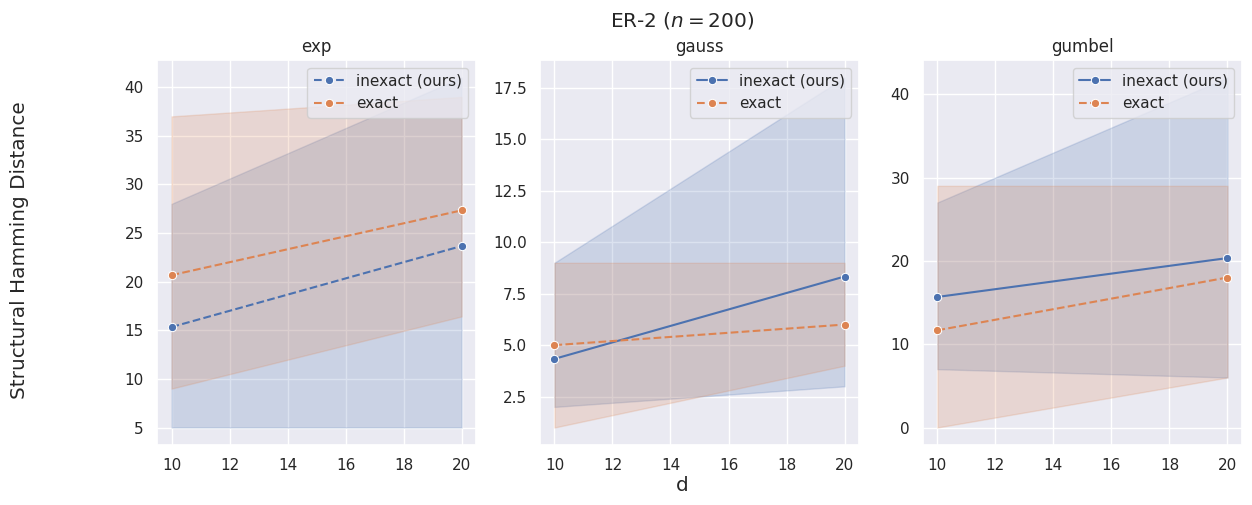

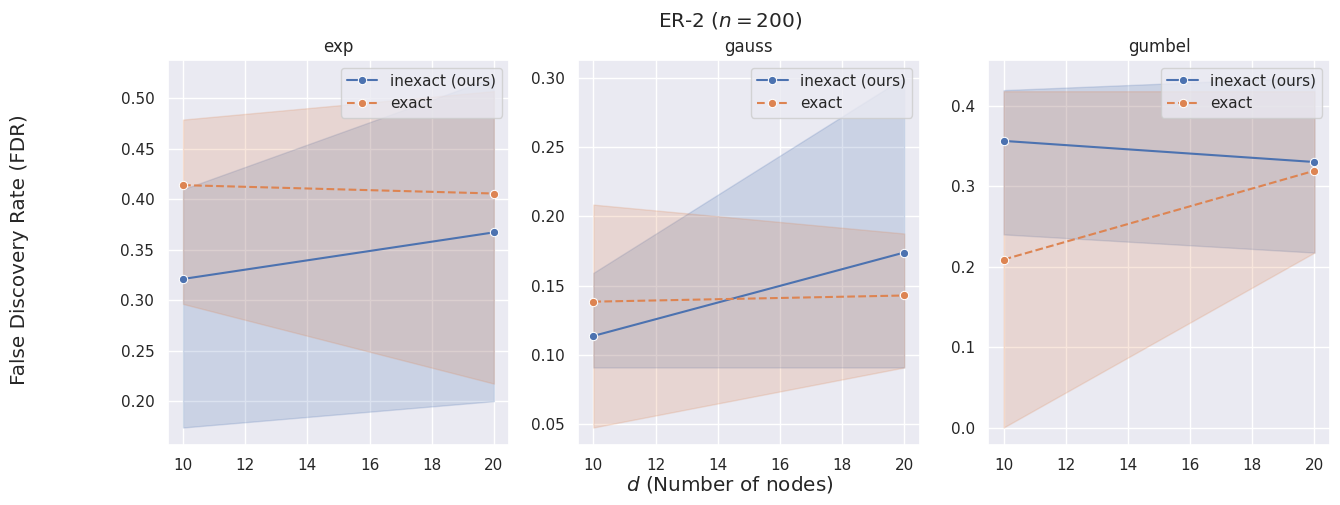

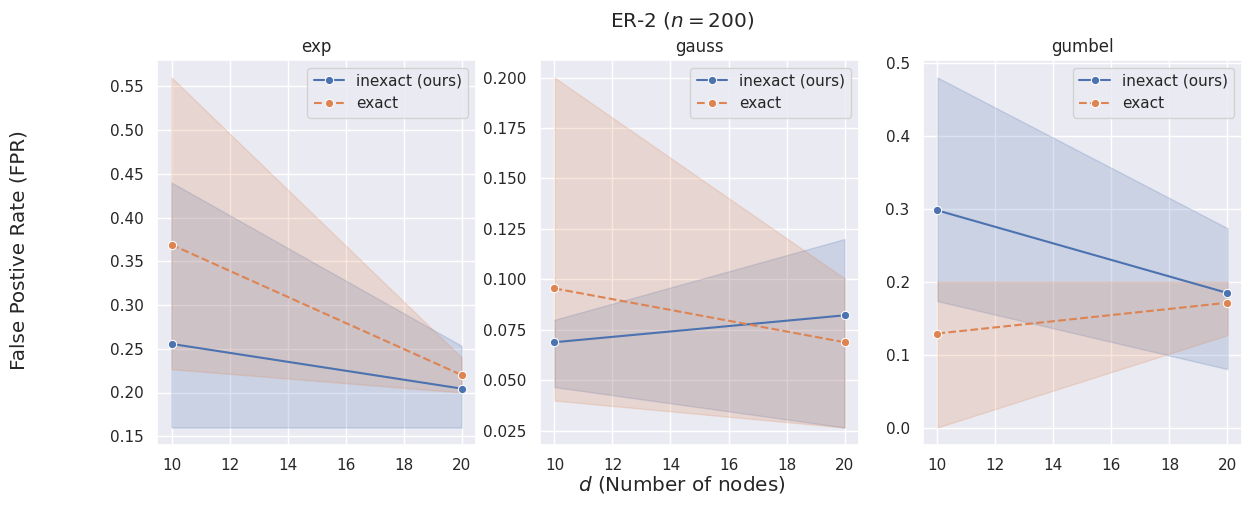

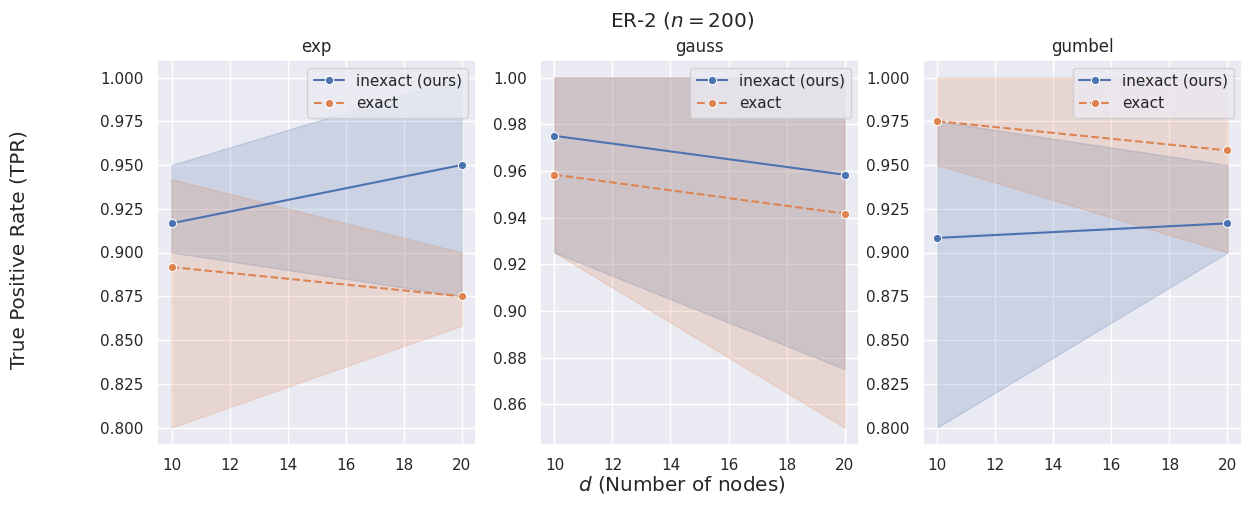

In [ ]:
d_vals = [10, 20, 40, 60, 100]

fig, axes = plt.subplots(1, 3, sharex=False, figsize=(16,5))
fig.suptitle(r'SF-2 ($n = 1000$)')
fig.supylabel('Structural Hamming Distance (SHD)')
fig.supxlabel(r'$d$ (Number of nodes)')
axes[0].set_title('exp')
axes[1].set_title('gauss')
axes[2].set_title('gumbel')

figFDR, axesFDR = plt.subplots(1, 3, sharex=False, figsize=(16,5))
figFDR.suptitle('SF-2 ($n = 1000$)')
figFDR.supylabel('False Discovery Rate (FDR)')
figFDR.supxlabel(r'$d$ (Number of nodes)')
axesFDR[0].set_title('exp')
axesFDR[1].set_title('gauss')
axesFDR[2].set_title('gumbel')

figFPR, axesFPR = plt.subplots(1, 3, sharex=False, figsize=(16,5))
figFPR.suptitle('SF-2 ($n = 1000$)')
figFPR.supylabel('False Postive Rate (FPR)')
figFPR.supxlabel(r'$d$ (Number of nodes)')
axesFPR[0].set_title('exp')
axesFPR[1].set_title('gauss')
axesFPR[2].set_title('gumbel')

figTPR, axesTPR = plt.subplots(1, 3, sharex=False, figsize=(16,5))
figTPR.suptitle('SF-2 ($n = 1000$)')
figTPR.supylabel('True Positive Rate (TPR)')
figTPR.supxlabel(r'$d$ (Number of nodes)')
axesTPR[0].set_title('exp')
axesTPR[1].set_title('gauss')
axesTPR[2].set_title('gumbel')


sns.lineplot(ax=axes[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_shd_results_ours, label= 'inexact (ours)', marker="o", err_style='band')
sns.lineplot(ax=axes[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_shd_results_original, label = 'exact', marker="o", linestyle = '--')
sns.lineplot(ax=axesFDR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fdr_results_ours, label= 'inexact (ours)', marker="o")
sns.lineplot(ax=axesFDR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fdr_results_original, label = 'exact', marker="o", linestyle = '--')
sns.lineplot(ax=axesFPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fpr_results_ours, label= 'inexact (ours)', marker="o")
sns.lineplot(ax=axesFPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_fpr_results_original, label = 'exact', marker="o", linestyle = '--')
sns.lineplot(ax=axesTPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_tpr_results_ours, label= 'inexact (ours)', marker="o")
sns.lineplot(ax=axesTPR[0], x=np.tile(d_vals, num_of_simulations+1), y=full_exp_tpr_results_original, label = 'exact', marker="o", linestyle = '--')


sns.lineplot(ax=axes[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_shd_results_ours, marker="o")
sns.lineplot(ax=axes[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_shd_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFDR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fdr_results_ours, marker="o")
sns.lineplot(ax=axesFDR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fdr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fpr_results_ours, marker="o")
sns.lineplot(ax=axesFPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_fpr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesTPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_tpr_results_ours, marker="o")
sns.lineplot(ax=axesTPR[1], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gauss_tpr_results_original, marker="o", linestyle = '--')


sns.lineplot(ax=axes[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_shd_results_ours, marker="o")
sns.lineplot(ax=axes[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_shd_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFDR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fdr_results_ours, marker="o")
sns.lineplot(ax=axesFDR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fdr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesFPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fpr_results_ours, marker="o")
sns.lineplot(ax=axesFPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_fpr_results_original, marker="o", linestyle = '--')
sns.lineplot(ax=axesTPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_tpr_results_ours, marker="o")
sns.lineplot(ax=axesTPR[2], x=np.tile(d_vals[:-1], num_of_simulations+1), y=full_gumbel_tpr_results_original, marker="o", linestyle = '--')


axes[0].get_legend().remove()
axesTPR[0].get_legend().remove()
axesFPR[0].get_legend().remove()
axesFDR[0].get_legend().remove()
fig.legend(loc='right')
figTPR.legend(loc='right')
figFDR.legend(loc='right')
figFPR.legend(loc='right')

axes[0].set_xticks(d_vals) # <--- set the ticks first
axes[0].set_xticklabels(d_vals)
axes[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axes[1].set_xticklabels(d_vals[:-1])
axes[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axes[2].set_xticklabels(d_vals[:-1])

axesTPR[0].set_xticks(d_vals) # <--- set the ticks first
axesTPR[0].set_xticklabels(d_vals)
axesTPR[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesTPR[1].set_xticklabels(d_vals[:-1])
axesTPR[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesTPR[2].set_xticklabels(d_vals[:-1])

axesFPR[0].set_xticks(d_vals) # <--- set the ticks first
axesFPR[0].set_xticklabels(d_vals)
axesFPR[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFPR[1].set_xticklabels(d_vals[:-1])
axesFPR[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFPR[2].set_xticklabels(d_vals[:-1])

axesFDR[0].set_xticks(d_vals) # <--- set the ticks first
axesFDR[0].set_xticklabels(d_vals)
axesFDR[1].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFDR[1].set_xticklabels(d_vals[:-1])
axesFDR[2].set_xticks(d_vals[:-1]) # <--- set the ticks first
axesFDR[2].set_xticklabels(d_vals[:-1])

## Using real data

Exact Method

In [ ]:
solver = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = True)
n, d, s0, graph_type, sem_type = 7466, 11, 35, 'ER', 'gauss'
solver.d = d
B_true = solver.simulate_dag(d, s0, graph_type)
W_true = solver.simulate_parameter(B_true)
np.savetxt('W_true.csv', W_true, delimiter=',')

solver.X = np.nan_to_num(np.load('Sachs.npy'))

In [ ]:
%%time
random.seed(1)
np.random.seed(1)
W_est, rhos, alphas, _ = solver.solve()

Iteration 1
2.777144045482446
Iteration 2
0.310446447565484
Iteration 3
0.07052444158863835
Iteration 4
0.015556087401105145
Iteration 5
0.003521536643987133
Iteration 6
0.0008236247270012598
Iteration 7
0.00020517487908655596
Iteration 8
1.4567909371265841e-05
Iteration 9
2.788024913158438e-06
Iteration 10
4.813155776162148e-07
Iteration 11
1.1124227228265227e-07
Iteration 12
6.849813516396352e-08
{'fdr': 0.41025641025641024, 'tpr': 0.6571428571428571, 'fpr': 0.8, 'shd': 23, 'nnz': 39}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa75974a470>>
CPU times: user 43.9 s, sys: 46.4 s, total: 1min 30s
Wall time: 1min 1s


Inexact Method (ours)

In [ ]:
solver2 = NOTEARS(weight_threshold= 0.1, max_rho= 1e16, max_iter= 100, h_tol= 1e-8, lambda1= 0.1, originalMethod = False)
solver2.d = d
solver2.X = solver.X
random.seed(1)
np.random.seed(1)

In [ ]:
%%time
W_est_new_ours, rhos_ours, alphas_ours, _ = solver2.solve()

Iteration 1
2.7761087331245733
Iteration 2
0.2358694744499541
Iteration 3
0.029924263498672943
Iteration 4
0.0031466656041843066
Iteration 5
0.000306368262890544
Iteration 6
3.7721298497217504e-05
Iteration 7
3.7908656036478305e-06
Iteration 8
4.705682172811976e-07
Iteration 9
8.666899375953108e-08
Iteration 10
8.666899375953108e-08
{'fdr': 0.4358974358974359, 'tpr': 0.6285714285714286, 'fpr': 0.85, 'shd': 25, 'nnz': 39}
<bound method NOTEARS.objective_and_gradient of <__main__.NOTEARS object at 0x7fa7590d7310>>
CPU times: user 34.7 s, sys: 32.1 s, total: 1min 6s
Wall time: 39.7 s
